In [23]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm, invgamma, gamma
from scipy.linalg import sqrtm
from scipy.optimize import minimize
import pandas as pd
from tqdm import tqdm

# Корзина опционов

Пример (Krekel, 2004). В рамках модели Блэка-Шоулза вычислите цены опциона колл на корзину с четырьмя акциями, для которых $T = 5~лет$, безрисковая ставка $r = 0$, корреляция $\rho_{ij} = 0,5$, $\forall i \neq j$, $K = 100$, $F^T_i = 100$, $σ_i = 40\%$ и $w_i = 0,25, i, j = 1, 2, 3, 4$.

Используйте аппроксимацию различными методами
* метод условного математического ожидания (Beisser),
* аппроксимация геометрическим средним (Gentel),
* метод моментов (Levy),
* **метод Джу через разложения в ряд Тейлора** (Ju),
* аппроксимация через обратное геометрическое распределение (MP-RG),
* **метод моментов высших порядков** (MP-4M)

и
сравните полученные аппроксимации с методом Монте-Карло.

In [24]:
T = 5
r = 0
K = 100
N = 4

rho0 = 0.5
rho  = np.ones((N,N)) * rho0 + np.diag(np.ones(N)) * (1 - rho0)
S0   = 100
S    = np.ones(N) * S0
F    = np.ones(N) * S0 * np.exp(r * T)
w    = np.ones(N) / N
q   = np.zeros(N)
sigma = np.ones(N) * 0.4
delta = np.zeros(N)

In [25]:
rho

array([[1. , 0.5, 0.5, 0.5],
       [0.5, 1. , 0.5, 0.5],
       [0.5, 0.5, 1. , 0.5],
       [0.5, 0.5, 0.5, 1. ]])

## Аппроксимация геометрическим средним (Gentel)

In [26]:
# аппроксимация корзины опционов геометрическим средним
def geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  a = w * F / np.sum(w * F)

  m_tilde = np.log(np.sum(w * F)) - 0.5 * np.sum(a * sigma ** 2 * T)
  v_tilde = np.sqrt((a * sigma).T @ rho @ (a * sigma) * T)

  K_star =  K - np.sum(w * F) + np.exp(m_tilde + 0.5 * v_tilde ** 2)

  d1 = (m_tilde - np.log(K_star) + v_tilde ** 2) / v_tilde
  d2 = d1 - v_tilde

  basket_call = np.exp(-r * T) * (np.exp(m_tilde + 0.5 * v_tilde ** 2) * norm.cdf(d1) - K_star * norm.cdf(d2))

  return basket_call

In [27]:
geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)

np.float64(23.783632811454414)

## Метод условного математического ожидания (Beisser)

In [28]:
def get_z_star(x, S, K, r, q, sigma, T, w, rho):
    res = 0
    a = S * w * sigma
    sqrt_T = np.sqrt(T)
    sigmaz = np.sqrt(a.T @ rho @ a)
    for i in range(0, len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        exp_S_Z = S[i] * np.exp(sigma[i] * m * x - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        res += w[i] * exp_S_Z
    return (res - K)**2

def Beisser_approximation_basket_call(S, K, T, w, r, q, sigma):
  basket_call = 0
  a = S * w * sigma
  sigmaz = np.sqrt(a.T @ rho @ a)
  sqrt_T = np.sqrt(T)

  z_star = minimize(get_z_star, 0, args=(S, K, r, q, sigma, T, w, rho)).x[0]
  for i in range(0, len(w)):
    m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
    sigma_star = sigma[i] * m * sigmaz / np.sqrt(T)
    K_star = S[i] * np.exp(sigma[i] * m * z_star - 1/2 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
    S_star = S[i] * np.exp((r - q[i] - 1/2 * sigma_star**2) * T + sigma_star * np.sqrt(T) / sigmaz * z_star)
    d1 = (np.log(S[i] / K_star) + (r - q[i] + 1/2 * sigma_star**2) * T) / (sigma_star * np.sqrt(T))
    d2 = d1 - sigma_star * np.sqrt(T)
    basket_call += w[i] * (np.exp(-q[i] * T) * S[i] * norm.cdf(d1) - np.exp(-r * T) * K_star * norm.cdf(d2))
    return basket_call

In [29]:
Beisser_approximation_basket_call(S, K, T, w, r, q, sigma)

np.float64(6.908159755754296)

## Задача

### Метод Джу через разложения в ряд Тейлора (Ju)

Статья [(Ju, 2002)](https://drive.google.com/file/d/1JJuZhRiCUGf6euyfju1Dn5aRP46-3iry/view?usp=drive_link)

In [30]:
import numpy as np
from scipy.stats import norm

def ju_taylor_approximation_call(S, K, T, sigma, w, rho, r=0, delta=None):
    N = len(S)
    if delta is None:
        delta = np.zeros(N)
    
    mu_B = np.sum(w * S * np.exp((r - delta) * T))
    cov_returns = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            cov_returns[i, j] = rho[i, j] * sigma[i] * sigma[j] * T
    var_B = np.dot(w, np.dot(cov_returns, w))
    std_B = np.sqrt(var_B)
    skew_B = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                skew_B += w[i] * w[j] * w[k] * sigma[i] * sigma[j] * sigma[k] * T ** 1.5 * \
                          (rho[i, j] * rho[i, k] * rho[j, k])
    skew_B /= std_B ** 3
    kurt_B = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    kurt_B += w[i] * w[j] * w[k] * w[l] * sigma[i] * sigma[j] * sigma[k] * sigma[l] * T ** 2 * \
                              (rho[i, j] * rho[i, k] * rho[i, l] * rho[j, k] * rho[j, l] * rho[k, l])
    kurt_B = kurt_B / std_B ** 4 - 3
    d = (np.log(mu_B / K)) / std_B
    d_adj = d + (skew_B / 6) * (d ** 2 - 1) + (kurt_B / 24) * (d ** 3 - 3 * d) - \
            (skew_B ** 2 / 36) * (2 * d ** 3 - 5 * d)
    d2_adj = d_adj - std_B
    Nd_adj = norm.cdf(d_adj)
    Nd2_adj = norm.cdf(d2_adj)

    basket_call = np.exp(-r * T) * (mu_B * Nd_adj - K * Nd2_adj)

    return basket_call

basket_call_price = ju_taylor_approximation_call(S, K, T, sigma, w, rho, r, delta)
print("Basket Call Price using Ju's Taylor Expansion Method:", basket_call_price)

Basket Call Price using Ju's Taylor Expansion Method: 25.20527283818404


## Метод моментов (Log-normal moment matching, Levy’s matching)

In [31]:
def Levy_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  m = 2 * np.log(M) - 1/2 * np.log(V2)
  v = np.sqrt(np.log(V2) - 2 * np.log(M))
  d1 = (m - np.log(K) + v**2) / v
  d2 = d1 - v
  basket_call = np.exp(-r * T) * (M * norm.cdf(d1) - K * norm.cdf(d2))
  return basket_call

In [32]:
Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)

np.float64(28.051966214249894)

## Аппроксимация через обратное геометрическое распределение (MP-RG)

In [33]:
def Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma):
  F = S * np.exp(r * T)
  M = np.dot(w, F)
  V2 = 0
  for i in range(0, len(w)):
    for j in range(0, len(w)):
      V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
  alpha = (2 * V2  - M**2) / (V2 - M**2)
  beta = (V2 - M**2) / (V2 * M)
  g1 = gamma.cdf(1/K, a = alpha - 1, scale = beta)
  g2 = gamma.cdf(1/K, a = alpha, scale = beta)
  basket_call = np.exp(-r * T) * (M * g1 - K * g2)
  return basket_call

In [34]:
Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)

np.float64(24.495775089623557)

## Задача

### Метод моментов высоких порядков (MP-4M)

Статья [(Posner and Milevsky, 1998)](https://https://drive.google.com/file/d/16f5dRiA_HD9jhm-esUT_6gGoArk9Nc2u/view?usp=drive_link)

Basket Call Option Price (4M Approximation): 27.51
Basket Call Option Price (Monte Carlo): 27.71


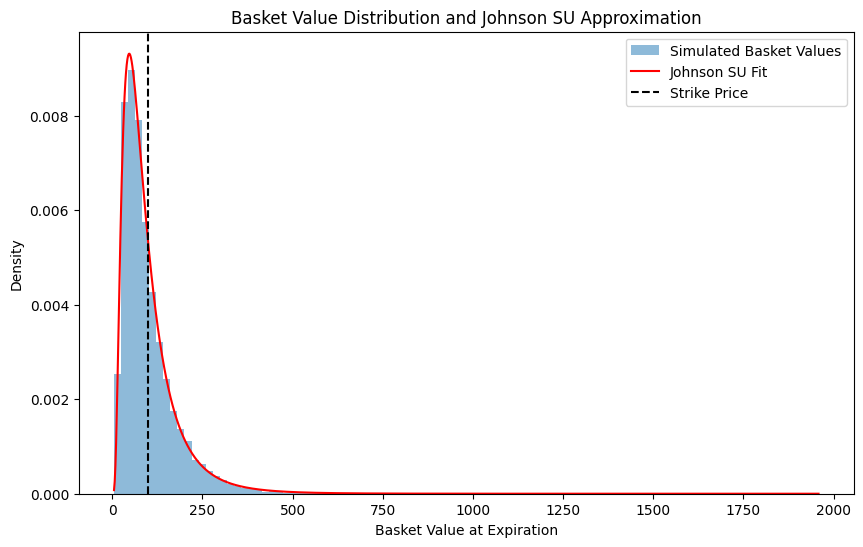

In [35]:
from scipy.stats import johnsonsu
from scipy.integrate import quad

def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):
    """
    Calculates the price of a basket call option using the Milevsky-Posner 4M approximation method.

    Parameters:
    S     : np.array, initial prices of the underlying assets
    K     : float, strike price of the option
    T     : float, time to expiration
    w     : np.array, weights of the assets in the basket
    r     : float, risk-free interest rate
    rho   : np.array, correlation matrix of the assets
    sigma : np.array, volatilities of the assets

    Returns:
    basket_call : float, the approximated price of the basket call option
    """

    N = len(S)
    mu = (r - 0.5 * sigma**2) * T
    cov_matrix = np.outer(sigma, sigma) * rho * T

    num_samples = 10000
    np.random.seed(0)
    log_S = np.random.multivariate_normal(mu, cov_matrix, num_samples)
    S_T = S * np.exp(log_S)
    B_T = np.dot(S_T, w)

    mean_BT = np.mean(B_T)
    std_BT = np.std(B_T)
    skew_BT = np.mean((B_T - mean_BT)**3) / std_BT**3
    kurt_BT = np.mean((B_T - mean_BT)**4) / std_BT**4

    params = johnsonsu.fit(B_T)
    a, b, loc, scale = params

    def integrand(x):
        return (x - K) * johnsonsu.pdf(x, a, b, loc=loc, scale=scale)

    expected_payoff, _ = quad(integrand, K, np.inf)

    basket_call = np.exp(-r * T) * expected_payoff

    print(f"Basket Call Option Price (4M Approximation): {basket_call:.2f}")

    payoffs = np.maximum(B_T - K, 0)
    mc_price = np.exp(-r * T) * np.mean(payoffs)
    print(f"Basket Call Option Price (Monte Carlo): {mc_price:.2f}")

    plt.figure(figsize=(10, 6))
    x = np.linspace(min(B_T), max(B_T), 1000)
    pdf_fitted = johnsonsu.pdf(x, a, b, loc=loc, scale=scale)
    plt.hist(B_T, bins=100, density=True, alpha=0.5, label='Simulated Basket Values')
    plt.plot(x, pdf_fitted, 'r-', label='Johnson SU Fit')
    plt.axvline(K, color='k', linestyle='--', label='Strike Price')
    plt.title('Basket Value Distribution and Johnson SU Approximation')
    plt.xlabel('Basket Value at Expiration')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    return basket_call

basket_call_price = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)


## Метод Монте-Карло

In [36]:
def MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  basket_call = np.mean(np.maximum(B_T - K, 0)) * np.exp(-r * T)
  return basket_call

In [37]:
N_mc = int(10**6)
MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)

np.float64(27.952864389718634)

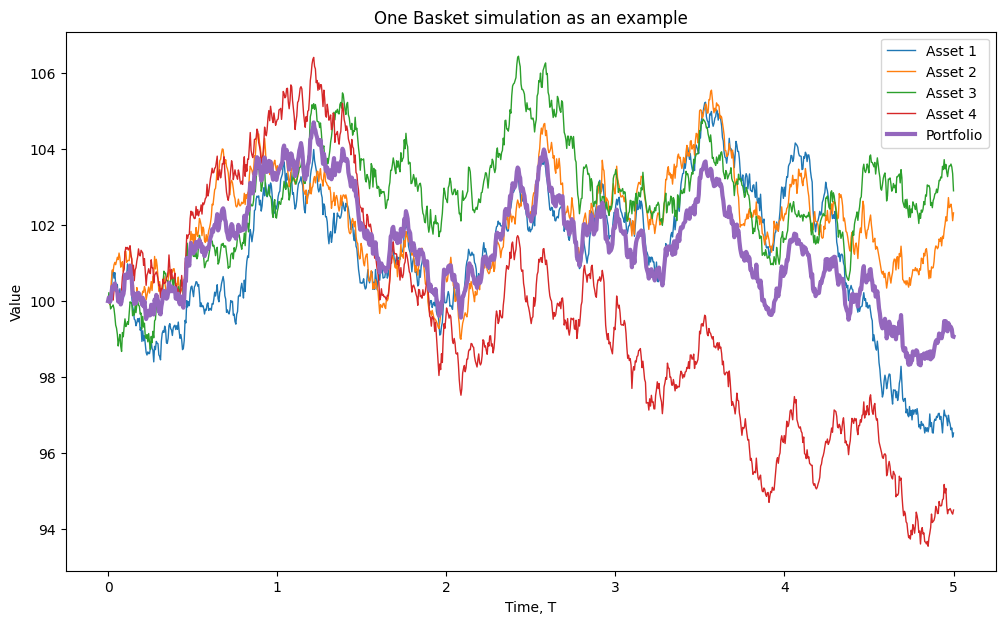

In [38]:
# Пример одной симуляции методом Монте-Карло для равновесной корзины опционов

n_steps = 1000
dt = T / (n_steps - 1)
S_t = np.zeros((n_steps, 4))
S_t[0] = F
COV = sigma.T * rho * sigma
for i in range(n_steps - 1):
    dW = np.random.multivariate_normal(np.zeros(4), COV) * dt
    dS = r * S_t[i] * dt + S_t[i] * dW
    S_t[i + 1] = S_t[i] + dS

plt.figure(figsize=(12, 7))
t_grid = np.linspace(0, T, n_steps)
plt.plot(t_grid, S_t, lw=1, label = [f'Asset {i + 1}' for i in range(N)])
plt.plot(t_grid, S_t @ w, lw=3,  label='Portfolio')
plt.xlabel('Time, T')
plt.ylabel('Value')
plt.title('One Basket simulation as an example')
plt.legend()
plt.show()

In [43]:
# МС оценка для кол и пут опционов
n_steps = 5000
N_sims = 10000
dt = T / (n_steps - 1)
COV = sigma.T * rho * sigma

S = np.zeros((N_sims, 4))
S[...] = F

for i in tqdm(range(n_steps - 1)):
    dW = np.random.multivariate_normal(np.zeros(4), COV, size=N_sims) * np.sqrt(dt)
    dS = r * S * dt + S * dW
    S += dS

portfolio_values = S @ w

call_price_mc = np.maximum(portfolio_values - K, 0).mean()
put_price_mc = np.maximum(K - portfolio_values, 0).mean()

print('Call price by Monte-Carlo:', call_price_mc)
print('Put price by Monte-Carlo:', put_price_mc)

100%|██████████| 4999/4999 [00:03<00:00, 1323.07it/s]

Call price by Monte-Carlo: 27.29645261069399
Put price by Monte-Carlo: 28.050262984903465


Пример. Для метода Монте-Карло реализуйте функцию для вычисления стандартного отклонения
$
StdDev = \sqrt{\frac{1}{n}\sum_{i=1}^n(Price - MC\,Price)^2}
$
и постройте доверительный интервал для оценки.

In [44]:
def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
  n = len(w)
  COV = sigma.T * rho * sigma
  W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
  B_T = np.zeros(N_mc)
  S0 = 100
  for k in range(0, n):
      B_T += S[k] * np.exp((r - q[k] - sigma[k]**2 / 2) * T + W[:,k]) * w[k]
  payoff = np.maximum(B_T - K, 0)
  mean = np.mean(payoff) * np.exp(-r * T)
  std = np.std(payoff) * np.exp(-r * T)
  return call_price_mc, std

def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # lower bound of confidence interval for the price
    hi = price + norm.ppf(0.975)*price_std / np.sqrt(N_mc)    # upper bound of confidence interval for the price
    print(f"mean call basket price = {price}, ci: {lo} < price < {hi} with 95% prob")

In [45]:
MC_call, MC_std = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc)
CI_MC(MC_call, MC_std, N_mc)

ValueError: operands could not be broadcast together with shapes (4,) (1000000,) 

### Задача

Выполнение симуляций Монте-Карло: 100%|██████████| 1000/1000 [00:00<00:00, 1012.23it/s]


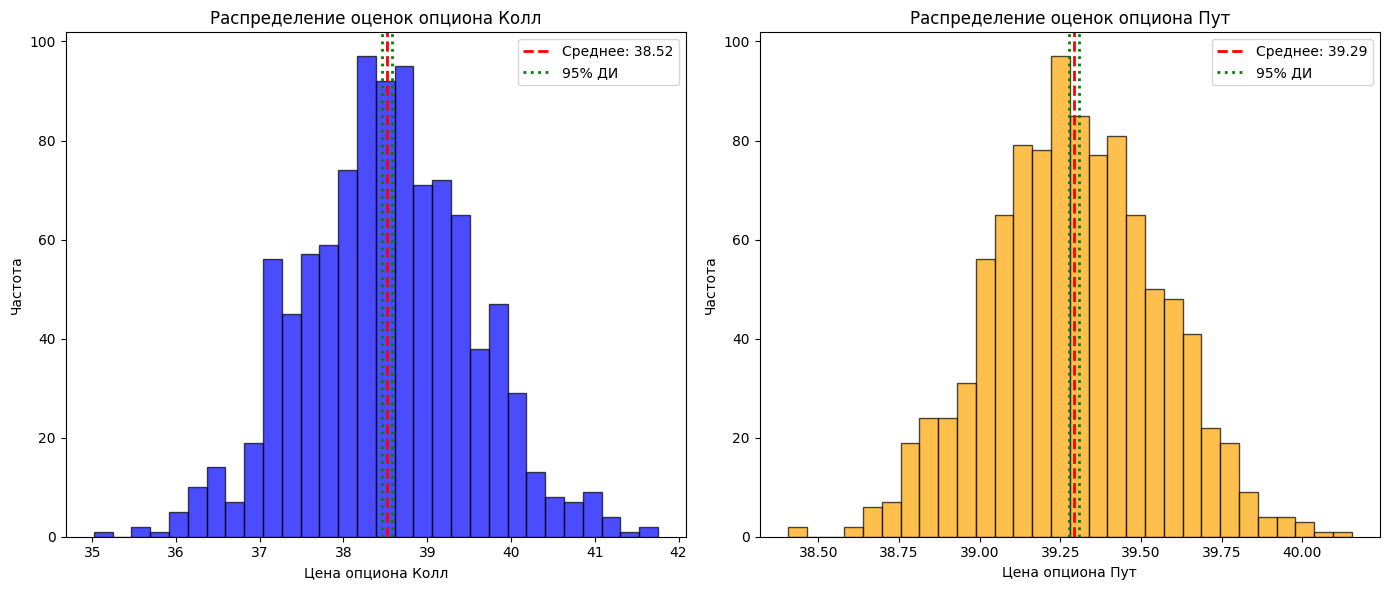

Тест Шапиро-Уилка для опциона Колл:
Статистика теста = 0.9987, p-значение = 0.6787
Не отвергаем гипотезу о нормальности распределения оценок опциона Колл.

Тест Шапиро-Уилка для опциона Пут:
Статистика теста = 0.9993, p-значение = 0.9694
Не отвергаем гипотезу о нормальности распределения оценок опциона Пут.

Средняя цена опциона Колл: 38.5223
Доверительный интервал 95% для опциона Колл: [38.4597, 38.5848]

Средняя цена опциона Пут: 39.2921
Доверительный интервал 95% для опциона Пут: [39.2759, 39.3083]


In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro
from tqdm import tqdm


def MC_basket_call_put(S, K, T, w, r, q, rho, sigma, N_mc):
    n = len(w)
    COV = np.outer(sigma, sigma) * rho * T
    Z = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc)
    S_T = S * np.exp((r - 0.5 * sigma**2) * T + Z)
    B_T = np.dot(S_T, w)
    payoffs_call = np.maximum(B_T - K, 0)
    payoffs_put = np.maximum(K - B_T, 0)
    call_price = np.exp(-r * T) * payoffs_call
    put_price = np.exp(-r * T) * payoffs_put
    return call_price, put_price

def analyze_MC_distribution(S, K, T, w, r, q, rho, sigma, N_mc, M):
    call_prices = []
    put_prices = []
    
    for _ in tqdm(range(M), desc="Выполнение симуляций Монте-Карло"):
        call, put = MC_basket_call_put(S, K, T, w, r, q, rho, sigma, N_mc)
        call_mean = np.mean(call)
        put_mean = np.mean(put)
        call_prices.append(call_mean)
        put_prices.append(put_mean)
    
    call_prices = np.array(call_prices)
    put_prices = np.array(put_prices)
    
    call_mean = np.mean(call_prices)
    call_std = np.std(call_prices)
    put_mean = np.mean(put_prices)
    put_std = np.std(put_prices)
    
    z = norm.ppf(0.975)
    call_ci_low = call_mean - z * call_std / np.sqrt(M)
    call_ci_high = call_mean + z * call_std / np.sqrt(M)
    put_ci_low = put_mean - z * put_std / np.sqrt(M)
    put_ci_high = put_mean + z * put_std / np.sqrt(M)
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(call_prices, bins=30, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(call_mean, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {call_mean:.2f}')
    plt.axvline(call_ci_low, color='green', linestyle='dotted', linewidth=2, label='95% ДИ')
    plt.axvline(call_ci_high, color='green', linestyle='dotted', linewidth=2)
    plt.title('Распределение оценок опциона Колл')
    plt.xlabel('Цена опциона Колл')
    plt.ylabel('Частота')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(put_prices, bins=30, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(put_mean, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {put_mean:.2f}')
    plt.axvline(put_ci_low, color='green', linestyle='dotted', linewidth=2, label='95% ДИ')
    plt.axvline(put_ci_high, color='green', linestyle='dotted', linewidth=2)
    plt.title('Распределение оценок опциона Пут')
    plt.xlabel('Цена опциона Пут')
    plt.ylabel('Частота')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    stat_call, p_call = shapiro(call_prices)
    stat_put, p_put = shapiro(put_prices)
    
    print("Тест Шапиро-Уилка для опциона Колл:")
    print(f"Статистика теста = {stat_call:.4f}, p-значение = {p_call:.4f}")
    if p_call > 0.05:
        print("Не отвергаем гипотезу о нормальности распределения оценок опциона Колл.\n")
    else:
        print("Отвергаем гипотезу о нормальности распределения оценок опциона Колл.\n")
    
    print("Тест Шапиро-Уилка для опциона Пут:")
    print(f"Статистика теста = {stat_put:.4f}, p-значение = {p_put:.4f}")
    if p_put > 0.05:
        print("Не отвергаем гипотезу о нормальности распределения оценок опциона Пут.\n")
    else:
        print("Отвергаем гипотезу о нормальности распределения оценок опциона Пут.\n")
        
    return {
        'call_prices': call_prices,
        'put_prices': put_prices,
        'call_mean': call_mean,
        'call_std': call_std,
        'call_ci_low': call_ci_low,
        'call_ci_high': call_ci_high,
        'put_mean': put_mean,
        'put_std': put_std,
        'put_ci_low': put_ci_low,
        'put_ci_high': put_ci_high
    }

N_mc = 10000
M = 1000

results = analyze_MC_distribution(S, K, T, w, r, q, rho, sigma, N_mc, M)

print(f"Средняя цена опциона Колл: {results['call_mean']:.4f}")
print(f"Доверительный интервал 95% для опциона Колл: [{results['call_ci_low']:.4f}, {results['call_ci_high']:.4f}]\n")
print(f"Средняя цена опциона Пут: {results['put_mean']:.4f}")
print(f"Доверительный интервал 95% для опциона Пут: [{results['put_ci_low']:.4f}, {results['put_ci_high']:.4f}]")


## Исследование влияния параметров модели на оценку стоимости корзины опцинов

Пример.
Проведите исследование влияния параметров (варьировать один параметр, остальные -- зафиксировать) для различных методов аппроксимации и постройте графики, на которых отобразите зависимость для следующих значений параметров:  

* цена страйк $K=\{50, 60, \ldots, 150\}$,
* форвардная цена $F^T=\{50, 60, \ldots, 150\}$,
* корреляция  $\rho=\{0.1, 0.2, \ldots, 0.9, 0.95\}$,
* волатильность $\sigma=\{0.1, 0.2, \ldots, 0.9, 1.0\}$,
* веса $w_1 = \{0.5, 0.2, 0.2, 0.1\}$, $w_2 = \{0.7, 0.1, 0.1, 0.1\}$,
* безрисковая ставка $r=\{0.01, 0.02, 0.05, 0.1\}$.


### Задача.

In [ ]:
# На графики добавить кривые, полученные для методов Ju и MP-4M,
# предложите свою визуализацию для корзин с разными весами активов
# ваш код допишите в ячейке ниже

In [47]:
import numpy as np
from scipy.stats import norm, gamma, johnsonsu
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt
from tqdm import tqdm

N_mc = 100000 
#Аппроксимация корзины опционов геометрическим средним (Gentel)
def geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma):
    F = S * np.exp(r * T)
    a = w * F / np.sum(w * F)
    
    m_tilde = np.log(np.sum(w * F)) - 0.5 * np.sum(a * sigma ** 2 * T)
    v_tilde = np.sqrt((a * sigma).T @ rho @ (a * sigma) * T)
    
    K_star = K - np.sum(w * F) + np.exp(m_tilde + 0.5 * v_tilde ** 2)
    
    d1 = (m_tilde - np.log(K_star) + v_tilde ** 2) / v_tilde
    d2 = d1 - v_tilde
    
    basket_call = np.exp(-r * T) * (np.exp(m_tilde + 0.5 * v_tilde ** 2) * norm.cdf(d1) - K_star * norm.cdf(d2))
    
    return basket_call

#Метод условного математического ожидания (Beisser)
def get_z_star(x, S, K, r, q, sigma, T, w, rho):
    res = 0
    a = S * w * sigma
    sqrt_T = np.sqrt(T)
    sigmaz = np.sqrt(a.T @ rho @ a)
    for i in range(len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        exp_S_Z = S[i] * np.exp(sigma[i] * m * x - 0.5 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        res += w[i] * exp_S_Z
    return (res - K)**2

def Beisser_approximation_basket_call(S, K, T, w, r, q, sigma, rho):
    a = S * w * sigma
    sigmaz = np.sqrt(a.T @ rho @ a)
    sqrt_T = np.sqrt(T)
    
    #Поиск z_star
    result = minimize(get_z_star, 0, args=(S, K, r, q, sigma, T, w, rho))
    z_star = result.x[0]
    
    basket_call = 0
    for i in range(len(w)):
        m = np.sum(a * rho[i]) / sigmaz**2 * sqrt_T
        sigma_star = sigma[i] * m * sigmaz / np.sqrt(T)
        K_star = S[i] * np.exp(sigma[i] * m * z_star - 0.5 * sigma[i]**2 * m**2 * sigmaz**2 + (r - q[i]) * T)
        S_star = S[i] * np.exp((r - q[i] - 0.5 * sigma_star**2) * T + sigma_star * np.sqrt(T) / sigmaz * z_star)
        d1 = (np.log(S[i] / K_star) + (r - q[i] + 0.5 * sigma_star**2) * T) / (sigma_star * np.sqrt(T))
        d2 = d1 - sigma_star * np.sqrt(T)
        basket_call += w[i] * (np.exp(-q[i] * T) * S[i] * norm.cdf(d1) - np.exp(-r * T) * K_star * norm.cdf(d2))
    return basket_call

#Метод моментов (Levy)
def Levy_approximation_basket_call(S, K, T, w, r, rho, sigma):
    F = S * np.exp(r * T)
    M = np.dot(w, F)
    V2 = 0
    for i in range(len(w)):
        for j in range(len(w)):
            V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
    m = 2 * np.log(M) - 0.5 * np.log(V2)
    v = np.sqrt(np.log(V2) - 2 * np.log(M))
    d1 = (m - np.log(K) + v**2) / v
    d2 = d1 - v
    basket_call = np.exp(-r * T) * (M * norm.cdf(d1) - K * norm.cdf(d2))
    return basket_call

#Метод Джу через разложения в ряд Тейлора (Ju)
def ju_taylor_approximation_call(S, K, T, sigma, w, rho, r=0, delta=None):
    N = len(S)
    if delta is None:
        delta = np.zeros(N)
    
    mu_B = np.sum(w * S * np.exp((r - delta) * T))
    cov_returns = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            cov_returns[i, j] = rho[i, j] * sigma[i] * sigma[j] * T
    var_B = np.dot(w, np.dot(cov_returns, w))
    std_B = np.sqrt(var_B)
    
    #Вычисление skewness и kurtosis
    skew_B = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                skew_B += w[i] * w[j] * w[k] * sigma[i] * sigma[j] * sigma[k] * T ** 1.5 * \
                          (rho[i, j] * rho[i, k] * rho[j, k])
    skew_B /= std_B ** 3
    
    kurt_B = 0
    for i in range(N):
        for j in range(N):
            for k in range(N):
                for l in range(N):
                    kurt_B += w[i] * w[j] * w[k] * w[l] * sigma[i] * sigma[j] * sigma[k] * sigma[l] * T ** 2 * \
                              (rho[i, j] * rho[i, k] * rho[i, l] * rho[j, k] * rho[j, l] * rho[k, l])
    kurt_B = kurt_B / std_B ** 4 - 3
    
    #Аппроксимация распределения через ряд Тейлора
    d = (np.log(mu_B / K)) / std_B
    d_adj = d + (skew_B / 6) * (d ** 2 - 1) + (kurt_B / 24) * (d ** 3 - 3 * d) - \
            (skew_B ** 2 / 36) * (2 * d ** 3 - 5 * d)
    d2_adj = d_adj - std_B
    Nd_adj = norm.cdf(d_adj)
    Nd2_adj = norm.cdf(d2_adj)

    basket_call = np.exp(-r * T) * (mu_B * Nd_adj - K * Nd2_adj)

    return basket_call

#Аппроксимация через обратное геометрическое распределение (Milevsky-Posner RG)
def Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma):
    F = S * np.exp(r * T)
    M = np.dot(w, F)
    V2 = 0
    for i in range(len(w)):
        for j in range(len(w)):
            V2 += w[i] * w[j] * F[i] * F[j] * np.exp(sigma[i] * sigma[j] * rho[i][j] * T)
    alpha = (2 * V2 - M**2) / (V2 - M**2)
    beta = (V2 - M**2) / (V2 * M)
    #Используем гамма-распределение вместо обратного геометрического для упрощения
    g1 = gamma.cdf(1/K, a=alpha - 1, scale=beta)
    g2 = gamma.cdf(1/K, a=alpha, scale=beta)
    basket_call = np.exp(-r * T) * (M * g1 - K * g2)
    return basket_call

#Метод моментов высших порядков (MP-4M)
def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):
    """
    Рассчитывает цену корзинного опциона колл методом моментов высших порядков (4M).
    """
    # Расчет моментов через Монте-Карло для большей точности
    num_samples = 100000
    np.random.seed(0)
    log_S = np.random.multivariate_normal(
        (r - 0.5 * sigma**2) * T, 
        np.outer(sigma, sigma) * rho * T, 
        num_samples
    )
    S_T = S * np.exp(log_S)
    B_T = np.dot(S_T, w)
    
    mean_BT = np.mean(B_T)
    std_BT = np.std(B_T)
    skew_BT = np.mean((B_T - mean_BT)**3) / std_BT**3
    kurt_BT = np.mean((B_T - mean_BT)**4) / std_BT**4
    
    #Аппроксимация распределения Johnson SU
    params = johnsonsu.fit(B_T)
    a, b, loc, scale = params
    
    def integrand(x):
        return (x - K) * johnsonsu.pdf(x, a, b, loc=loc, scale=scale)
    
    expected_payoff, _ = quad(integrand, K, np.inf)
    
    basket_call = np.exp(-r * T) * expected_payoff
    
    return basket_call

#Метод Монте-Карло
def MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc):
    n = len(w)
    COV = np.outer(sigma, sigma) * rho * T
    W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc)
    S_T = S * np.exp((r - q - 0.5 * sigma**2) * T + W)
    B_T = np.dot(S_T, w)
    payoff = np.maximum(B_T - K, 0)
    basket_call = np.exp(-r * T) * np.mean(payoff)
    return basket_call

#Функция для расчета стандартного отклонения и доверительного интервала
def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc):
    n = len(w)
    COV = np.outer(sigma, sigma) * rho * T
    W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc)
    S_T = S * np.exp((r - q - 0.5 * sigma**2) * T + W)
    B_T = np.dot(S_T, w)
    payoff = np.maximum(B_T - K, 0)
    mean = np.exp(-r * T) * np.mean(payoff)
    std = np.std(payoff) * np.exp(-r * T)
    return mean, std

def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975) * price_std / np.sqrt(N_mc)    # Нижняя граница доверительного интервала
    hi = price + norm.ppf(0.975) * price_std / np.sqrt(N_mc)    # Верхняя граница доверительного интервала
    print(f"mean call basket price = {price:.4f}, ci: {lo:.4f} < price < {hi:.4f} с 95% вероятностью")

call_price_mc, std_mc = MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc)
CI_MC(call_price_mc, std_mc, N_mc)

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
fig.tight_layout(pad=5.0)


def calculate_prices(S, K, T, w, r, q, rho, sigma, N_mc):
    geom_avg = geometric_average_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Beisser_price = Beisser_approximation_basket_call(S, K, T, w, r, q, sigma, rho)
    Levy_price = Levy_approximation_basket_call(S, K, T, w, r, rho, sigma)
    Ju_price = ju_taylor_approximation_call(S, K, T, sigma, w, rho, r, delta=None)
    MP_RG_price = Milevsky_Posner_RG_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MP_4M_price = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
    MC_price = MC_basket_call(S, K, T, w, r, q, rho, sigma, N_mc)
    return geom_avg, Beisser_price, Levy_price, Ju_price, MP_RG_price, MP_4M_price, MC_price

iters = 20
K_data = np.linspace(50, 150, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S, K_data[i], T, w, r, q, rho, sigma, N_mc)

axs[0][0].plot(K_data, geom_avg, label='Geometric average')
axs[0][0].plot(K_data, Beisser, label='Beisser')
axs[0][0].plot(K_data, Levy, label='Levy')
axs[0][0].plot(K_data, Ju_prices, label='Ju (Taylor)')
axs[0][0].plot(K_data, MP_RG, label='Milevsky-Posner RG')
axs[0][0].plot(K_data, MP_4M, label='Milevsky-Posner 4M')
axs[0][0].plot(K_data, MC, label='Monte-Carlo')
axs[0][0].set_title('Зависимость цены корзинного опциона от K')
axs[0][0].set_xlabel('Страйк K')
axs[0][0].set_ylabel('Цена опциона')
axs[0][0].legend(loc='best', fancybox=True, shadow=True)
axs[0][0].grid(True)


iters = 20
F_data = np.linspace(50, 150, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    S_new = F_data[i] * np.ones(N) * np.exp(-r * T)
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S_new, K, T, w, r, q, rho, sigma, N_mc)

axs[0][1].plot(F_data, geom_avg, label='Geometric average')
axs[0][1].plot(F_data, Beisser, label='Beisser')
axs[0][1].plot(F_data, Levy, label='Levy')
axs[0][1].plot(F_data, Ju_prices, label='Ju (Taylor)')
axs[0][1].plot(F_data, MP_RG, label='Milevsky-Posner RG')
axs[0][1].plot(F_data, MP_4M, label='Milevsky-Posner 4M')
axs[0][1].plot(F_data, MC, label='Monte-Carlo')
axs[0][1].set_title('Зависимость цены корзинного опциона от F')
axs[0][1].set_xlabel('Форвардная цена F')
axs[0][1].set_ylabel('Цена опциона')
axs[0][1].legend(loc='best', fancybox=True, shadow=True)
axs[0][1].grid(True)

iters = 20
sigma_data = np.linspace(0.1, 1.0, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    sigma_new = np.ones(N) * sigma_data[i]
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S, K, T, w, r, q, rho, sigma_new, N_mc)

axs[1][0].plot(sigma_data, geom_avg, label='Geometric average')
axs[1][0].plot(sigma_data, Beisser, label='Beisser')
axs[1][0].plot(sigma_data, Levy, label='Levy')
axs[1][0].plot(sigma_data, Ju_prices, label='Ju (Taylor)')
axs[1][0].plot(sigma_data, MP_RG, label='Milevsky-Posner RG')
axs[1][0].plot(sigma_data, MP_4M, label='Milevsky-Posner 4M')
axs[1][0].plot(sigma_data, MC, label='Monte-Carlo')
axs[1][0].set_title('Зависимость цены корзинного опциона от волатильности σ')
axs[1][0].set_xlabel('Волатильность σ')
axs[1][0].set_ylabel('Цена опциона')
axs[1][0].legend(loc='best', fancybox=True, shadow=True)
axs[1][0].grid(True)

iters = 20
r_data = np.linspace(0.01, 0.1, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    r_new = r_data[i]
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S, K, T, w, r_new, q, rho, sigma, N_mc)

axs[1][1].plot(r_data, geom_avg, label='Geometric average')
axs[1][1].plot(r_data, Beisser, label='Beisser')
axs[1][1].plot(r_data, Levy, label='Levy')
axs[1][1].plot(r_data, Ju_prices, label='Ju (Taylor)')
axs[1][1].plot(r_data, MP_RG, label='Milevsky-Posner RG')
axs[1][1].plot(r_data, MP_4M, label='Milevsky-Posner 4M')
axs[1][1].plot(r_data, MC, label='Monte-Carlo')
axs[1][1].set_title('Зависимость цены корзинного опциона от безрисковой ставки r')
axs[1][1].set_xlabel('Безрисковая ставка r')
axs[1][1].set_ylabel('Цена опциона')
axs[1][1].legend(loc='best', fancybox=True, shadow=True)
axs[1][1].grid(True)

iters = 20
rho_data = np.linspace(0.1, 0.95, iters)
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    rho_new = np.ones((N, N)) * rho_data[i] + np.diag(np.ones(N)) * (1 - rho_data[i])
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S, K, T, w, r, q, rho_new, sigma, N_mc)

axs[2][0].plot(rho_data, geom_avg, label='Geometric average')
axs[2][0].plot(rho_data, Beisser, label='Beisser')
axs[2][0].plot(rho_data, Levy, label='Levy')
axs[2][0].plot(rho_data, Ju_prices, label='Ju (Taylor)')
axs[2][0].plot(rho_data, MP_RG, label='Milevsky-Posner RG')
axs[2][0].plot(rho_data, MP_4M, label='Milevsky-Posner 4M')
axs[2][0].plot(rho_data, MC, label='Monte-Carlo')
axs[2][0].set_title('Зависимость цены корзинного опциона от корреляции ρ')
axs[2][0].set_xlabel('Корреляция ρ')
axs[2][0].set_ylabel('Цена опциона')
axs[2][0].legend(loc='best', fancybox=True, shadow=True)
axs[2][0].grid(True)

iters = 2
w_data = np.array([[0.5, 0.2, 0.2, 0.1], [0.7, 0.1, 0.1, 0.1]])
S_data = np.array([[50, 40, 60, 30], [50, 40, 60, 30]]) 
geom_avg = np.zeros(iters)
Beisser = np.zeros(iters)
Levy = np.zeros(iters)
Ju_prices = np.zeros(iters)
MP_RG = np.zeros(iters)
MP_4M = np.zeros(iters)
MC = np.zeros(iters)

for i in range(iters):
    S_current = S_data[i]
    w_current = w_data[i]
    geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S_current, K, T, w_current, r, q, rho, sigma, N_mc)

labels = ['Весовая комбинация 1', 'Весовая комбинация 2']

axs[2][1].plot(labels, geom_avg, marker='o', label='Geometric average')
axs[2][1].plot(labels, Beisser, marker='o', label='Beisser')
axs[2][1].plot(labels, Levy, marker='o', label='Levy')
axs[2][1].plot(labels, Ju_prices, marker='o', label='Ju (Taylor)')
axs[2][1].plot(labels, MP_RG, marker='o', label='Milevsky-Posner RG')
axs[2][1].plot(labels, MP_4M, marker='o', label='Milevsky-Posner 4M')
axs[2][1].plot(labels, MC, marker='o', label='Monte-Carlo')
axs[2][1].set_title('Зависимость цены корзинного опциона от весов активов')
axs[2][1].set_xlabel('Весовая комбинация')
axs[2][1].set_ylabel('Цена опциона')
axs[2][1].legend(loc='best', fancybox=True, shadow=True)
axs[2][1].grid(True)

plt.show()

def pdfs_comparison():
    iters = 100
    S_data = np.linspace(50, 150, iters)
    geom_avg = np.zeros(iters)
    Beisser = np.zeros(iters)
    Levy = np.zeros(iters)
    Ju_prices = np.zeros(iters)
    MP_RG = np.zeros(iters)
    MP_4M = np.zeros(iters)
    MC = np.zeros(iters)

    for i in range(iters):
        S_current = S_data[i] * np.ones(N)
        geom_avg[i], Beisser[i], Levy[i], Ju_prices[i], MP_RG[i], MP_4M[i], MC[i] = calculate_prices(S_current, K, T, w, r, q, rho, sigma, N_mc)

    plt.figure(figsize=(10, 6))
    plt.plot(S_data, geom_avg, label='Geometric average')
    plt.plot(S_data, Beisser, label='Beisser')
    plt.plot(S_data, Levy, label='Levy')
    plt.plot(S_data, Ju_prices, label='Ju (Taylor)')
    plt.plot(S_data, MP_RG, label='Milevsky-Posner RG')
    plt.plot(S_data, MP_4M, label='Milevsky-Posner 4M')
    plt.plot(S_data, MC, label='Monte-Carlo')
    plt.title('Сравнение методов аппроксимации корзинного опциона')
    plt.xlabel('Начальная цена S0')
    plt.ylabel('Цена опциона')
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    plt.show()


pdfs_comparison() 


ValueError: operands could not be broadcast together with shapes (10000,4) (100000,4) 

# Мини-проект (оценка корзины нейронной сетью)

Оцените корзину европейских опционов с помощью полносвязанной модели нейронной сети.

*  Сгенерируйте цены для $10 000$ опционных корзин, используя одну из аналитических аппроксимаций.
*  Обучите полностью связанную искусственную нейронную сеть для оценки стоиомости опционов.
*  Сравните полученные оценки с Монте-Карло оценками.
Приведите иллюстративные графики.


1. Корзина европейских опционов колл + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M
1. Корзина европейских опционов пут + Gentel
1. Корзина европейских опционов колл + Beisser
1. Корзина европейских опционов колл + Ju
1. Корзина европейских опционов колл + Levy
1. Корзина европейских опционов колл + MP-RG
1. Корзина европейских опционов колл + MP-4M

Option Pricing with Deep Learning

[Отчет](https://cs230.stanford.edu/projects_fall_2019/reports/26260984.pdf) [Постер](https://cs230.stanford.edu/projects_fall_2019/posters/26260929.pdf)
[Пример.](https://github.com/nluciw/pricing_basket_options/blob/main/main_analysis.ipynb)

In [48]:
import numpy as np
import pandas as pd
from scipy.stats import norm, johnsonsu
from scipy.integrate import quad
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models
import warnings
warnings.filterwarnings('ignore')


def Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma):
    """
    Вычисляет цену корзинного опциона методом Milevsky-Posner 4M.
    
    Параметры:
    S     : np.array, начальные цены активов
    K     : float, цена страйка
    T     : float, срок экспирации
    w     : np.array, веса активов в корзине
    r     : float, безрисковая ставка
    rho   : np.array, матрица корреляций
    sigma : np.array, волатильности активов
    
    Возвращает:
    basket_call : float, цена корзинного опциона
    """
    mu = (r - 0.5 * sigma**2) * T
    cov_matrix = np.outer(sigma, sigma) * rho * T
    
    num_samples = 1000 
    log_S = np.random.multivariate_normal(mu, cov_matrix, num_samples)
    S_T = S * np.exp(log_S)
    B_T = np.dot(S_T, w)
    
    params = johnsonsu.fit(B_T)
    a, b, loc, scale = params
    
    def integrand(x):
        return (x - K) * johnsonsu.pdf(x, a, b, loc=loc, scale=scale)
    
    expected_payoff, _ = quad(integrand, K, np.inf)
    
    basket_call = np.exp(-r * T) * expected_payoff
    return basket_call


In [50]:

num_samples = 10000



S_range = (80, 120)  #Начальные цены активов
sigma_range = (0.2, 0.6)  #Волатильности активов
w_fixed = np.array([0.25, 0.25, 0.25, 0.25]) #Для весов, будем использовать фиксированные веса, чтобы сумма равнялась 1

np.random.seed(42)
S_samples = np.random.uniform(S_range[0], S_range[1], size=(num_samples, N))
sigma_samples = np.random.uniform(sigma_range[0], sigma_range[1], size=(num_samples, N))
w_samples = np.tile(w_fixed, (num_samples, 1))

basket_prices = []
for i in tqdm(range(num_samples), desc="Генерация цен опционов"):
    S = S_samples[i]
    sigma = sigma_samples[i]
    w = w_samples[i]
    price = Milevsky_Posner_4M_approximation_basket_call(S, K, T, w, r, rho, sigma)
    basket_prices.append(price)

data = pd.DataFrame({
    'S1': S_samples[:,0],
    'S2': S_samples[:,1],
    'S3': S_samples[:,2],
    'S4': S_samples[:,3],
    'sigma1': sigma_samples[:,0],
    'sigma2': sigma_samples[:,1],
    'sigma3': sigma_samples[:,2],
    'sigma4': sigma_samples[:,3],
    'w1': w_samples[:,0],
    'w2': w_samples[:,1],
    'w3': w_samples[:,2],
    'w4': w_samples[:,3],
    'Price': basket_prices
})

print("Пример данных:")
print(data.head())


Генерация цен опционов: 100%|██████████| 10000/10000 [10:08<00:00, 16.43it/s]

Пример данных:
           S1          S2          S3          S4    sigma1    sigma2  \
0   94.981605  118.028572  109.279758  103.946339  0.319565  0.237927   
1   86.240746   86.239781   82.323344  114.647046  0.281461  0.296905   
2  104.044600  108.322903   80.823380  118.796394  0.403829  0.323552   
3  113.297706   88.493564   87.272999   87.336180  0.514991  0.569695   
4   92.169690  100.990257   97.277801   91.649166  0.373284  0.341789   

     sigma3    sigma4    w1    w2    w3    w4      Price  
0  0.250544  0.272268  0.25  0.25  0.25  0.25  22.689985  
1  0.302184  0.382287  0.25  0.25  0.25  0.25  18.490740  
2  0.562919  0.421256  0.25  0.25  0.25  0.25  30.138079  
3  0.265254  0.371150  0.25  0.25  0.25  0.25  31.438825  
4  0.203562  0.526389  0.25  0.25  0.25  0.25  28.304402  


In [89]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data.drop('Price', axis=1).values
y = data['Price'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [90]:

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,473 (68.25 KB)

 Trainable params: 17,473 (68.25 KB)

 Non-trainable params: 0 (0.00 B)

In [91]:

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
    ],
    verbose=1
)


Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 344.2534 - mae: 14.8264 - val_loss: 19.0427 - val_mae: 3.4746
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18.1302 - mae: 3.3623 - val_loss: 15.2103 - val_mae: 3.0896
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.3251 - mae: 3.1187 - val_loss: 12.9584 - val_mae: 2.8697
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - loss: 12.0392 - mae: 2.7595 - val_loss: 10.0832 - val_mae: 2.5199
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 9.5705 - mae: 2.4433 - val_loss: 7.9116 - val_mae: 2.2474
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 7.6185 - mae: 2.1841 - val_loss: 6.2579 - val_mae: 1.9823
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 6.0493 - mae: 1.9172 - val_loss: 6.0409 - val_mae: 1.9190
Epoch 8/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - loss: 5.5672 - mae: 1.8418 - val_loss: 5.4877 - val_mae: 1.8262
Epoch 9/100
175/175 ━━━━━━━━

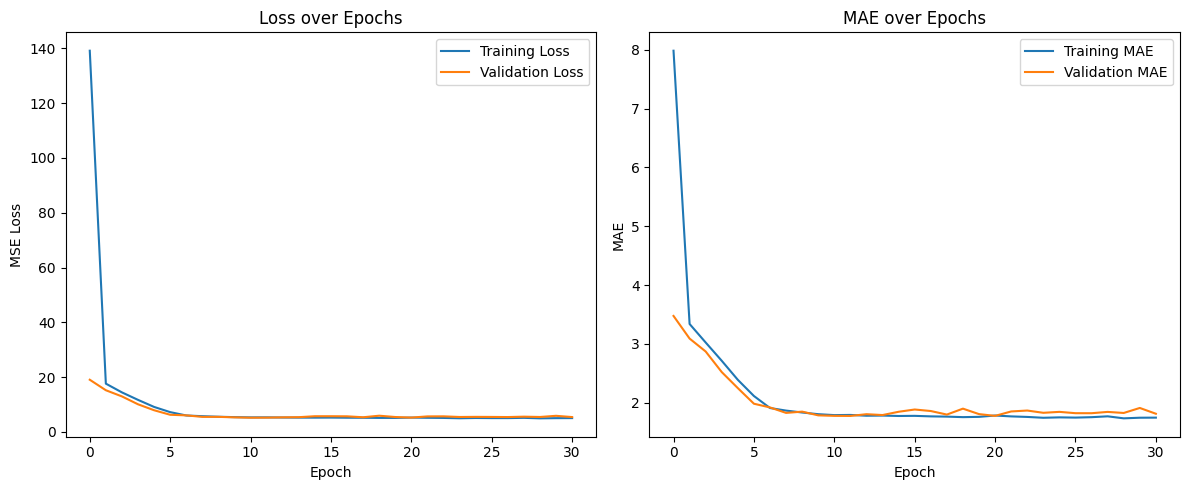

In [92]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()


In [93]:
def MC_basket_call_with_std(S, K, T, w, r, q, rho, sigma, N_mc=10000):
    """
    Оценивает цену корзинного опциона методом Монте-Карло.
    
    Параметры:
    S     : np.array, начальные цены активов
    K     : float, цена страйка
    T     : float, срок экспирации
    w     : np.array, веса активов в корзине
    r     : float, безрисковая ставка
    q     : np.array, дивиденды активов
    rho   : np.array, матрица корреляций
    sigma : np.array, волатильности активов
    N_mc  : int, количество симуляций
    
    Возвращает:
    call_price_mc : float, оценка цены опциона методом Монте-Карло
    std_dev      : float, стандартное отклонение оценок
    """
    n = len(w)
    COV = sigma.T * rho * sigma
    W = np.random.multivariate_normal(np.zeros(n), COV, size=N_mc) * np.sqrt(T)
    B_T = np.zeros(N_mc)
    for k in range(n):
        B_T += S[k] * np.exp((r - q[k] - 0.5 * sigma[k]**2) * T + W[:,k]) * w[k]
    payoff = np.maximum(B_T - K, 0)
    call_price_mc = np.mean(payoff) * np.exp(-r * T)
    std_dev = np.std(payoff) * np.exp(-r * T)
    return call_price_mc, std_dev


In [94]:
def compute_MC_prices(X, K, T, w, r, rho, sigma, N_mc=10000):
    """
    Вычисляет цены опционов методом Монте-Карло для набора данных.
    
    Параметры:
    X     : np.array, признаки (S1, S2, S3, S4, sigma1, sigma2, sigma3, sigma4, w1, w2, w3, w4)
    K     : float, цена страйка
    T     : float, срок экспирации
    w     : np.array, веса активов в корзине
    r     : float, безрисковая ставка
    rho   : np.array, матрица корреляций
    sigma : np.array, волатильности активов
    N_mc  : int, количество симуляций
    
    Возвращает:
    mc_prices : np.array, цены опционов
    mc_stds   : np.array, стандартные отклонения оценок
    """
    mc_prices = []
    mc_stds = []
    num_samples = X.shape[0]
    for i in tqdm(range(num_samples), desc="Вычисление цен методом Монте-Карло"):
        S = X[i, :4]
        sigma = X[i, 4:8]
        w_i = X[i, 8:12]
        q = np.zeros(N)  # Без дивидендов
        price, std = MC_basket_call_with_std(S, K, T, w_i, r, q, rho, sigma, N_mc)
        mc_prices.append(price)
        mc_stds.append(std)
    return np.array(mc_prices), np.array(mc_stds)

X_test_subset = X_test_scaled[:1000]
y_test_subset = y_test[:1000]

mc_prices, mc_stds = compute_MC_prices(X_test[:1000], K, T, w_fixed, r, rho, X_test[:,4:8], N_mc=1000)


Вычисление цен методом Монте-Карло: 100%|██████████| 1000/1000 [00:00<00:00, 4967.63it/s]


In [95]:
y_pred = model.predict(X_test_scaled[:1000]).flatten()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


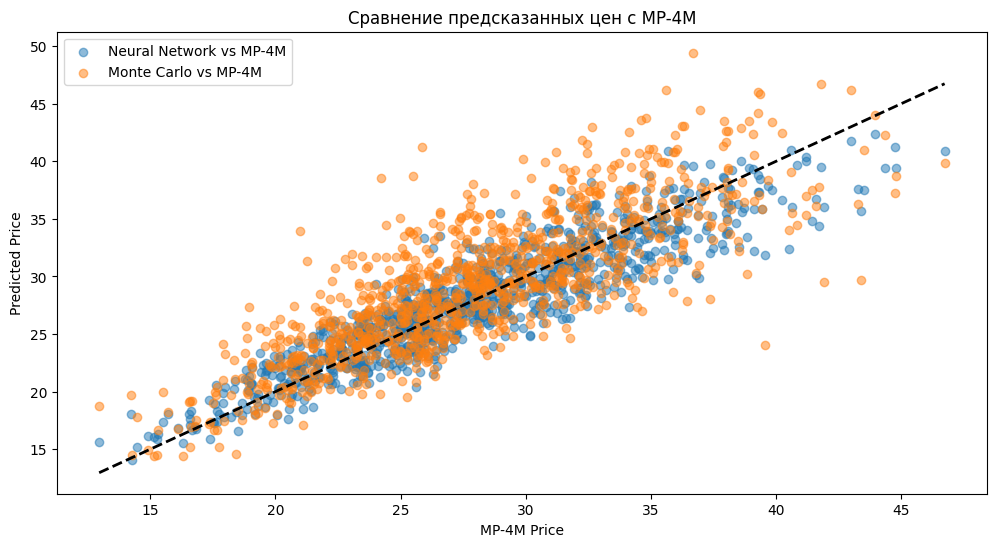

In [96]:
y_real = y_test_subset

plt.figure(figsize=(12, 6))
plt.scatter(y_real, y_pred, alpha=0.5, label='Neural Network vs MP-4M')
plt.scatter(y_real, mc_prices, alpha=0.5, label='Monte Carlo vs MP-4M')
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=2)
plt.xlabel('MP-4M Price')
plt.ylabel('Predicted Price')
plt.title('Сравнение предсказанных цен с MP-4M')
plt.legend()
plt.show()


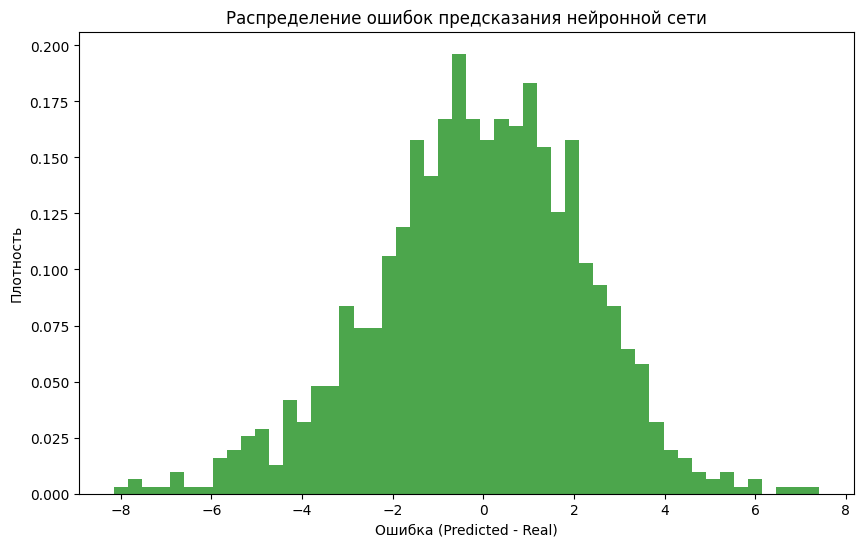

In [97]:
errors = y_pred - y_real

plt.figure(figsize=(10,6))
plt.hist(errors, bins=50, density=True, alpha=0.7, color='g')
plt.title('Распределение ошибок предсказания нейронной сети')
plt.xlabel('Ошибка (Predicted - Real)')
plt.ylabel('Плотность')
plt.show()


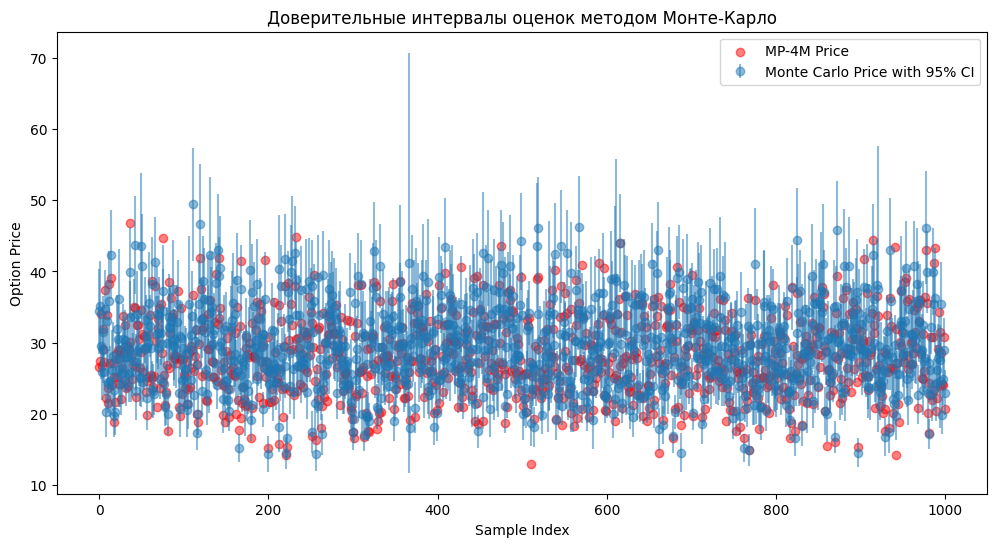

In [98]:
def CI_MC(price, price_std, N_mc):
    lo = price - norm.ppf(0.975)*price_std / np.sqrt(N_mc)
    hi = price + norm.ppf(0.975)*price_std / np.sqrt(N_mc)
    return lo, hi
ci_lo, ci_hi = CI_MC(mc_prices, mc_stds, N_mc=1000)

plt.figure(figsize=(12,6))
plt.errorbar(range(len(mc_prices)), mc_prices, yerr=norm.ppf(0.975)*mc_stds/np.sqrt(1000), fmt='o', alpha=0.5, label='Monte Carlo Price with 95% CI')
plt.scatter(range(len(y_real)), y_real, color='r', alpha=0.5, label='MP-4M Price')
plt.xlabel('Sample Index')
plt.ylabel('Option Price')
plt.title('Доверительные интервалы оценок методом Монте-Карло')
plt.legend()
plt.show()


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9484 - mae: 1.7319 - val_loss: 5.5960 - val_mae: 1.8323
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 4.9800 - mae: 1.7458 - val_loss: 5.7086 - val_mae: 1.8425
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 5.0006 - mae: 1.7394 - val_loss: 6.6326 - val_mae: 2.0293
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - loss: 5.0889 - mae: 1.7584 - val_loss: 5.7015 - val_mae: 1.8594
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 4.8418 - mae: 1.7232 - val_loss: 6.3664 - val_mae: 1.9691
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - loss: 4.8310 - mae: 1.7121 - val_loss: 6.4986 - val_mae: 1.9867
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 4.9954 - mae: 1.7420 - val_loss: 5.4674 - val_mae: 1.8222
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - loss: 4.8000 - mae: 1.7152 - val_loss: 5.5507 - val_mae: 1.8326
Epoch 9/100
200/200 ━━━━━━━━━━━━━━

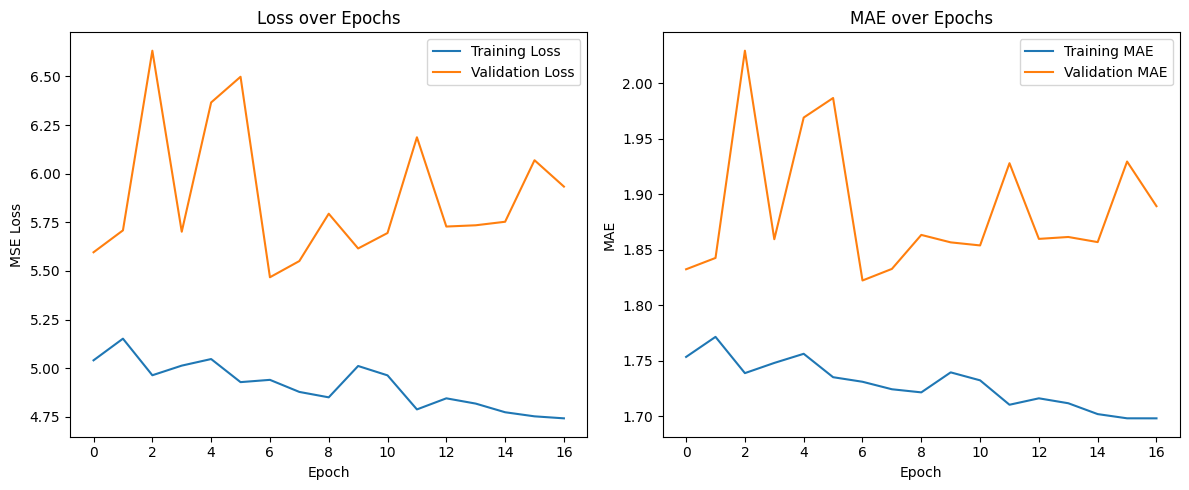

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step
Метрики на тестовом наборе:
Mean Absolute Error (MAE): 1.8574
Mean Squared Error (MSE): 5.5803
Root Mean Squared Error (RMSE): 2.3623
R² Score: 0.8331


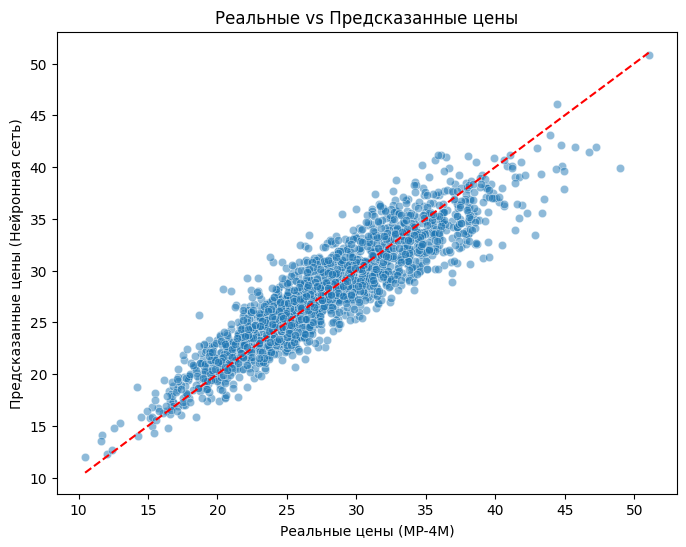

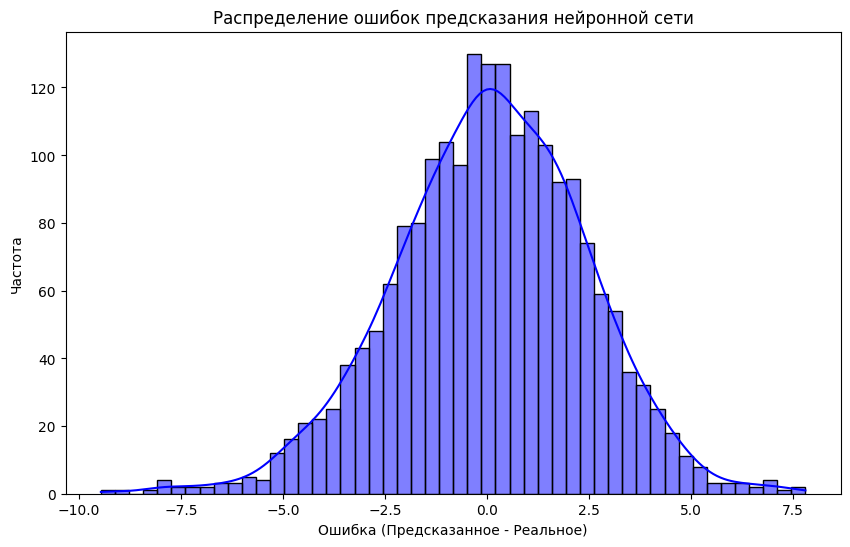

Вычисление цен методом Монте-Карло: 100%|██████████| 1000/1000 [00:00<00:00, 5064.56it/s]


Метрики для Нейронной сети:
MAE: 1.8574, MSE: 5.5803, RMSE: 2.3623, R²: 0.8331

Метрики для метода Монте-Карло:
MAE: 3.0323, MSE: 15.2211, RMSE: 3.9014, R²: 0.5286


In [103]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ],
    verbose=1
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

y_pred = model.predict(X_test_scaled).flatten()
y_real = y_test

mae = mean_absolute_error(y_real, y_pred)
mse = mean_squared_error(y_real, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_real, y_pred)

print("Метрики на тестовом наборе:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_real, y=y_pred, alpha=0.5)
plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--')
plt.xlabel('Реальные цены (MP-4M)')
plt.ylabel('Предсказанные цены (Нейронная сеть)')
plt.title('Реальные vs Предсказанные цены')
plt.show()

errors = y_pred - y_real
plt.figure(figsize=(10,6))
sns.histplot(errors, bins=50, kde=True, color='blue')
plt.title('Распределение ошибок предсказания нейронной сети')
plt.xlabel('Ошибка (Предсказанное - Реальное)')
plt.ylabel('Частота')
plt.show()

mc_prices, mc_stds = compute_MC_prices(X_test[:1000], K, T, w_fixed, r, rho, X_test[:1000,4:8], N_mc=1000)
mc_prices = mc_prices[:1000]
y_real_subset = y_test[:1000]

mae_mc = mean_absolute_error(y_real_subset, mc_prices)
mse_mc = mean_squared_error(y_real_subset, mc_prices)
rmse_mc = np.sqrt(mse_mc)
r2_mc = r2_score(y_real_subset, mc_prices)

print("\nМетрики для Нейронной сети:")
print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

print("\nМетрики для метода Монте-Карло:")
print(f"MAE: {mae_mc:.4f}, MSE: {mse_mc:.4f}, RMSE: {rmse_mc:.4f}, R²: {r2_mc:.4f}")


MAE: Нейронная сеть имеет значительно меньшую среднюю абсолютную ошибку (1.8574) по сравнению с методом Монте-Карло (3.0323). Это указывает на то, что предсказания Нейронной сети в среднем ближе к истинным значениям.

MSE и RMSE: Нейронная сеть демонстрирует гораздо меньшие значения MSE (5.5803) и RMSE (2.3623) по сравнению с методом Монте-Карло (MSE: 15.2211, RMSE: 3.9014). Это свидетельствует о меньшей вариативности и рассеянии ошибок предсказаний Нейронной сети.

R²: Коэффициент детерминации для Нейронной сети (0.8331) значительно выше, чем для метода Монте-Карло (0.5286). Это означает, что Нейронная сеть лучше объясняет вариативность данных и имеет более высокую предсказательную способность.
